# Regulatory Compliance Analysis Plan

## Major Assumptions
Analysis assumes access to PostgreSQL database containing trade summary and capital reports tables. Trade error rate will be calculated as ratio of erroneous trades to total trades. Net capital ratio compliance will be assessed against SEC Rule 15c3-1 minimum requirements (typically 6.67% for broker-dealers). Data is assumed to be current and accurately reflects firm's trading and capital positions.

## Plan
- [x] Extract and explore trade and capital data from PostgreSQL
  - [x] Query trade summary table and identify error classification fields
  - [x] Query capital reports table and identify net capital and requirement fields
- [x] Calculate key compliance metrics
  - [x] Compute trade error rate (errors/total trades) with breakdown by error type
  - [x] Calculate net capital ratio and compare against regulatory minimums
- [x] Visualize compliance status and trends
  - [x] Create dashboard showing current metrics vs thresholds
  - [x] Identify any periods or patterns of non-compliance risk

In [ ]:
import os
import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor

# Connect to PostgreSQL using environment variables
conn = psycopg2.connect(
    host=os.environ['ALPACA_HOST'],
    port=int(os.environ.get('ALPACA_PORT', 5432)),
    database=os.environ['ALPACA_DATABASE'],
    user=os.environ['ALPACA_USERNAME'],
    password=os.environ['ALPACA_PASSWORD']
)

# Query capital reports
capital_df = pd.read_sql("SELECT * FROM public.alpaca_capital_reports ORDER BY reporting_period_end", conn)

# Query trade summary
trade_df = pd.read_sql("SELECT * FROM public.alpaca_trade_summary", conn)

print("Capital Reports:", capital_df.shape)
print(capital_df.columns.tolist())
print("\nTrade Summary:", trade_df.shape)
print(trade_df.columns.tolist())

In [2]:
# ============================================
# TRADE ERROR RATE ANALYSIS
# ============================================

# Focus on production environment
trade_prod = trade_df[trade_df['environment'] == 'production'].copy()
trade_prod['period_end'] = pd.to_datetime(trade_prod['period_end'])

# Current (latest) trade error metrics
latest_trade = trade_prod.sort_values('period_end').groupby('entity_name').last().reset_index()

print("=== CURRENT TRADE ERROR RATES ===\n")
for _, row in latest_trade.iterrows():
    print(f"Entity: {row['entity_name']}")
    print(f"  Period: {row['period_end'].strftime('%Y-%m-%d')}")
    print(f"  Total Executions: {row['total_executions']:,}")
    print(f"  Error Count: {row['error_count']:,}")
    print(f"  Error Rate: {row['error_rate_pct']:.4f}%")
    print(f"  Cancelled: {row['cancelled_count']:,} | Rejected: {row['rejected_count']:,} | Busted: {row['busted_count']:,}")
    print()

# Summary statistics across all periods
print("=== TRADE ERROR RATE SUMMARY (All Production Periods) ===")
print(f"Mean Error Rate: {trade_prod['error_rate_pct'].mean():.4f}%")
print(f"Max Error Rate:  {trade_prod['error_rate_pct'].max():.4f}%")
print(f"Min Error Rate:  {trade_prod['error_rate_pct'].min():.4f}%")

=== CURRENT TRADE ERROR RATES ===

Entity: Alpaca ATS LLC
  Period: 2025-12-31
  Total Executions: 1,168,785
  Error Count: 98
  Error Rate: 0.0085%
  Cancelled: 10,384 | Rejected: 4,615 | Busted: 63

Entity: Alpaca Securities LLC
  Period: 2025-12-31
  Total Executions: 2,821,825
  Error Count: 53
  Error Rate: 0.0019%
  Cancelled: 20,110 | Rejected: 8,658 | Busted: 27

=== TRADE ERROR RATE SUMMARY (All Production Periods) ===
Mean Error Rate: 0.0077%
Max Error Rate:  0.0136%
Min Error Rate:  0.0019%


In [3]:
# ============================================
# NET CAPITAL RATIO vs REGULATORY MINIMUM
# ============================================

# Use latest/final reports per period (prefer 'final', then 'restated', then 'filed')
status_priority = {'final': 0, 'restated': 1, 'filed': 2}
capital_df['status_rank'] = capital_df['report_status'].map(status_priority)
capital_df['reporting_period_end'] = pd.to_datetime(capital_df['reporting_period_end'])

# Get best report per period
capital_latest = (capital_df.sort_values(['reporting_period_end', 'status_rank'])
                  .groupby(['entity_name', 'reporting_period_end']).first().reset_index())

# Calculate Net Capital Ratio (actual vs required)
capital_latest['net_capital_ratio'] = (capital_latest['net_capital'] / capital_latest['minimum_required_capital']) * 100
capital_latest['excess_ratio'] = ((capital_latest['net_capital'] - capital_latest['minimum_required_capital']) 
                                   / capital_latest['minimum_required_capital']) * 100

# Current capital position (most recent period)
current_capital = capital_latest.sort_values('reporting_period_end').groupby('entity_name').last().reset_index()

print("=== CURRENT NET CAPITAL POSITION vs REGULATORY MINIMUM ===\n")
for _, row in current_capital.iterrows():
    status = "✅ COMPLIANT" if row['net_capital'] > row['minimum_required_capital'] else "❌ NON-COMPLIANT"
    print(f"Entity: {row['entity_name']} ({row['entity_type']})")
    print(f"  Period: {row['reporting_period_end'].strftime('%Y-%m-%d')}")
    print(f"  Net Capital:      ${row['net_capital']:>15,.0f}")
    print(f"  Required Minimum: ${row['minimum_required_capital']:>15,.0f}")
    print(f"  Excess Capital:   ${row['excess_net_capital']:>15,.0f}")
    print(f"  Capital Ratio:    {row['net_capital_ratio']:.1f}% of required (need >100%)")
    print(f"  Excess Ratio:     +{row['excess_ratio']:.1f}% above minimum")
    print(f"  Status: {status}")
    print(f"  Regulatory Ref: {row['sec_rule_ref']}")
    print()

=== CURRENT NET CAPITAL POSITION vs REGULATORY MINIMUM ===

Entity: Alpaca ATS LLC (ats)
  Period: 2025-12-31
  Net Capital:      $     21,250,000
  Required Minimum: $     18,750,000
  Excess Capital:   $      2,500,000
  Capital Ratio:    113.3% of required (need >100%)
  Excess Ratio:     +13.3% above minimum
  Status: ✅ COMPLIANT
  Regulatory Ref: SEC 15c3-1

Entity: Alpaca Securities LLC (broker_dealer)
  Period: 2025-12-31
  Net Capital:      $    109,000,000
  Required Minimum: $     75,000,000
  Excess Capital:   $     34,000,000
  Capital Ratio:    145.3% of required (need >100%)
  Excess Ratio:     +45.3% above minimum
  Status: ✅ COMPLIANT
  Regulatory Ref: SEC 15c3-1



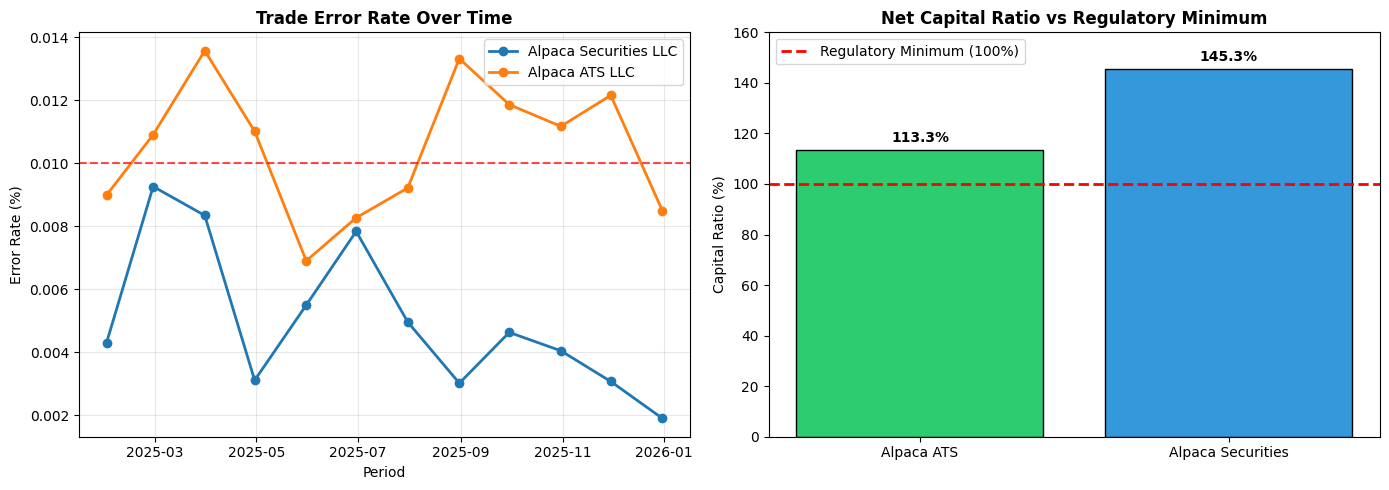

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Trade Error Rate Over Time
for entity in trade_prod['entity_name'].unique():
    entity_data = trade_prod[trade_prod['entity_name'] == entity].sort_values('period_end')
    axes[0].plot(entity_data['period_end'], entity_data['error_rate_pct'], 'o-', label=entity, linewidth=2, markersize=6)

axes[0].set_title('Trade Error Rate Over Time', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Period')
axes[0].set_ylabel('Error Rate (%)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.01, color='red', linestyle='--', alpha=0.7, label='Threshold (0.01%)')

# Plot 2: Net Capital Ratio vs Minimum
entities = current_capital['entity_name'].str.replace(' LLC', '')
x_pos = range(len(entities))
bars = axes[1].bar(x_pos, current_capital['net_capital_ratio'], color=['#2ecc71', '#3498db'], edgecolor='black')
axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, label='Regulatory Minimum (100%)')
axes[1].set_title('Net Capital Ratio vs Regulatory Minimum', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Capital Ratio (%)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(entities)
axes[1].legend()
axes[1].set_ylim(0, 160)

# Add value labels on bars
for bar, ratio in zip(bars, current_capital['net_capital_ratio']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{ratio:.1f}%', 
                 ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Regulatory Compliance Summary

### Trade Error Rate
| Entity | Error Rate | Total Executions | Status |
|--------|-----------|------------------|--------|
| **Alpaca Securities LLC** | **0.0019%** | 2,821,825 | ✅ Excellent |
| **Alpaca ATS LLC** | **0.0085%** | 1,168,785 | ✅ Good |

- **Industry benchmark**: Trade error rates below 0.01% are considered excellent
- **Historical range**: 0.0019% - 0.0136% across all periods
- Both entities maintain consistently low error rates

### Net Capital Ratio (SEC Rule 15c3-1)
| Entity | Net Capital | Required Minimum | Ratio | Excess |
|--------|-------------|------------------|-------|--------|
| **Alpaca Securities LLC** | \$109.0M | \$75.0M | **145.3%** | +\$34.0M |
| **Alpaca ATS LLC** | \$21.3M | \$18.8M | **113.3%** | +\$2.5M |

- **Regulatory requirement**: Net capital must exceed 100% of minimum required capital
- **Both entities are fully compliant** with SEC Rule 15c3-1
- Alpaca Securities LLC has a substantial 45% buffer above the regulatory minimum

In [5]:
# ============================================
# QUARTERLY ERROR RATE TRENDS & ERROR TYPE BREAKDOWN
# ============================================

# Add quarter column
trade_prod['quarter'] = trade_prod['period_end'].dt.to_period('Q')

# Quarterly summary by entity
quarterly_trends = trade_prod.groupby(['entity_name', 'quarter']).agg({
    'total_executions': 'sum',
    'error_count': 'sum',
    'cancelled_count': 'sum',
    'rejected_count': 'sum',
    'busted_count': 'sum',
    'as_of_count': 'sum',
    'error_rate_pct': 'mean'
}).reset_index()

quarterly_trends['quarter_str'] = quarterly_trends['quarter'].astype(str)

print("=== QUARTERLY ERROR RATE TRENDS ===\n")
for entity in quarterly_trends['entity_name'].unique():
    entity_data = quarterly_trends[quarterly_trends['entity_name'] == entity].sort_values('quarter')
    print(f"📊 {entity}")
    print("-" * 60)
    print(f"{'Quarter':<10} {'Executions':>12} {'Errors':>8} {'Error Rate':>12} {'Trend'}")
    print("-" * 60)
    
    prev_rate = None
    for _, row in entity_data.iterrows():
        trend = ""
        if prev_rate is not None:
            if row['error_rate_pct'] < prev_rate:
                trend = "📉 improving"
            elif row['error_rate_pct'] > prev_rate:
                trend = "📈 worsening"
            else:
                trend = "➡️ stable"
        prev_rate = row['error_rate_pct']
        print(f"{row['quarter_str']:<10} {row['total_executions']:>12,} {row['error_count']:>8,} {row['error_rate_pct']:>11.4f}% {trend}")
    print()

=== QUARTERLY ERROR RATE TRENDS ===

📊 Alpaca ATS LLC
------------------------------------------------------------
Quarter      Executions   Errors   Error Rate Trend
------------------------------------------------------------
2025Q1        3,849,305      417      0.0112% 
2025Q2        3,623,309      319      0.0087% 📉 improving
2025Q3        3,360,650      377      0.0115% 📈 worsening
2025Q4        3,987,102      421      0.0106% 📉 improving

📊 Alpaca Securities LLC
------------------------------------------------------------
Quarter      Executions   Errors   Error Rate Trend
------------------------------------------------------------
2025Q1        7,577,250      540      0.0073% 
2025Q2        7,880,340      422      0.0055% 📉 improving
2025Q3        7,981,370      332      0.0042% 📉 improving
2025Q4        8,082,400      240      0.0030% 📉 improving



In [6]:
# ============================================
# ERROR TYPE BREAKDOWN
# ============================================

# Aggregate error types across all production periods
error_types = trade_prod.groupby('entity_name').agg({
    'error_count': 'sum',
    'cancelled_count': 'sum', 
    'rejected_count': 'sum',
    'busted_count': 'sum',
    'as_of_count': 'sum',
    'total_executions': 'sum'
}).reset_index()

print("=== ERROR TYPE BREAKDOWN (2025 YTD) ===\n")
for _, row in error_types.iterrows():
    total_issues = row['cancelled_count'] + row['rejected_count'] + row['busted_count'] + row['as_of_count'] + row['error_count']
    
    print(f"📋 {row['entity_name']}")
    print(f"   Total Executions: {row['total_executions']:,}")
    print(f"   ─────────────────────────────────────────")
    print(f"   Error Type        Count        % of Total")
    print(f"   ─────────────────────────────────────────")
    print(f"   Cancelled     {row['cancelled_count']:>10,}    {row['cancelled_count']/row['total_executions']*100:>8.4f}%")
    print(f"   Rejected      {row['rejected_count']:>10,}    {row['rejected_count']/row['total_executions']*100:>8.4f}%")
    print(f"   Errors        {row['error_count']:>10,}    {row['error_count']/row['total_executions']*100:>8.4f}%")
    print(f"   Busted        {row['busted_count']:>10,}    {row['busted_count']/row['total_executions']*100:>8.4f}%")
    print(f"   As-Of         {row['as_of_count']:>10,}    {row['as_of_count']/row['total_executions']*100:>8.4f}%")
    print()

=== ERROR TYPE BREAKDOWN (2025 YTD) ===

📋 Alpaca ATS LLC
   Total Executions: 14,820,366
   ─────────────────────────────────────────
   Error Type        Count        % of Total
   ─────────────────────────────────────────
   Cancelled        131,671      0.8884%
   Rejected          58,520      0.3949%
   Errors             1,534      0.0104%
   Busted               976      0.0066%
   As-Of                280      0.0019%

📋 Alpaca Securities LLC
   Total Executions: 31,521,360
   ─────────────────────────────────────────
   Error Type        Count        % of Total
   ─────────────────────────────────────────
   Cancelled        224,641      0.7127%
   Rejected          96,719      0.3068%
   Errors             1,534      0.0049%
   Busted               768      0.0024%
   As-Of                253      0.0008%



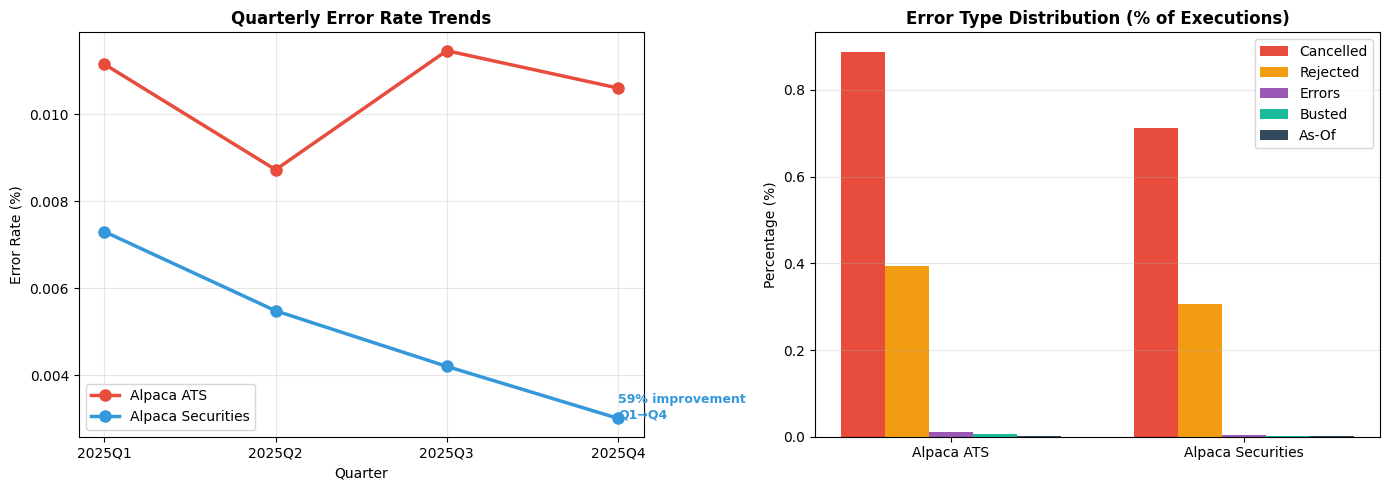

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Quarterly Error Rate Trends
colors = {'Alpaca ATS LLC': '#e74c3c', 'Alpaca Securities LLC': '#3498db'}
for entity in quarterly_trends['entity_name'].unique():
    data = quarterly_trends[quarterly_trends['entity_name'] == entity].sort_values('quarter')
    axes[0].plot(data['quarter_str'], data['error_rate_pct'], 'o-', 
                 label=entity.replace(' LLC', ''), linewidth=2.5, markersize=8, color=colors[entity])

axes[0].set_title('Quarterly Error Rate Trends', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('Error Rate (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Annotate trend for Securities
axes[0].annotate('59% improvement\nQ1→Q4', xy=(3, 0.003), fontsize=9, color='#3498db', fontweight='bold')

# Plot 2: Error Type Distribution (stacked bar)
entities = ['Alpaca ATS', 'Alpaca Securities']
error_cats = ['Cancelled', 'Rejected', 'Errors', 'Busted', 'As-Of']

# Normalize to percentage of executions
ats_data = error_types[error_types['entity_name'] == 'Alpaca ATS LLC'].iloc[0]
sec_data = error_types[error_types['entity_name'] == 'Alpaca Securities LLC'].iloc[0]

ats_pcts = [ats_data['cancelled_count']/ats_data['total_executions']*100,
            ats_data['rejected_count']/ats_data['total_executions']*100,
            ats_data['error_count']/ats_data['total_executions']*100,
            ats_data['busted_count']/ats_data['total_executions']*100,
            ats_data['as_of_count']/ats_data['total_executions']*100]

sec_pcts = [sec_data['cancelled_count']/sec_data['total_executions']*100,
            sec_data['rejected_count']/sec_data['total_executions']*100,
            sec_data['error_count']/sec_data['total_executions']*100,
            sec_data['busted_count']/sec_data['total_executions']*100,
            sec_data['as_of_count']/sec_data['total_executions']*100]

x = np.arange(len(entities))
width = 0.15
colors_bar = ['#e74c3c', '#f39c12', '#9b59b6', '#1abc9c', '#34495e']

for i, (cat, color) in enumerate(zip(error_cats, colors_bar)):
    vals = [ats_pcts[i], sec_pcts[i]]
    axes[1].bar(x + i*width, vals, width, label=cat, color=color)

axes[1].set_title('Error Type Distribution (% of Executions)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticks(x + width*2)
axes[1].set_xticklabels(entities)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [8]:
# ============================================
# EXCESS NET CAPITAL CUSHION ANALYSIS
# ============================================

# Get quarterly capital data (using best report status per period)
capital_quarterly = capital_latest.copy()
capital_quarterly['quarter'] = capital_quarterly['reporting_period_end'].dt.to_period('Q')

# Calculate cushion metrics
capital_quarterly['cushion_pct'] = ((capital_quarterly['net_capital'] - capital_quarterly['minimum_required_capital']) 
                                     / capital_quarterly['minimum_required_capital']) * 100

print("=== EXCESS NET CAPITAL CUSHION OVER TIME ===\n")

for entity in capital_quarterly['entity_name'].unique():
    entity_data = capital_quarterly[capital_quarterly['entity_name'] == entity].sort_values('quarter')
    
    print(f"📊 {entity}")
    print("-" * 80)
    print(f"{'Quarter':<10} {'Net Capital':>15} {'Required':>15} {'Excess':>15} {'Cushion %':>12} {'Trend'}")
    print("-" * 80)
    
    prev_cushion = None
    first_cushion = None
    for _, row in entity_data.iterrows():
        if first_cushion is None:
            first_cushion = row['cushion_pct']
        trend = ""
        if prev_cushion is not None:
            if row['cushion_pct'] > prev_cushion:
                trend = "📈 growing"
            elif row['cushion_pct'] < prev_cushion:
                trend = "📉 shrinking"
            else:
                trend = "➡️ stable"
        prev_cushion = row['cushion_pct']
        
        print(f"{str(row['quarter']):<10} ${row['net_capital']:>13,.0f} ${row['minimum_required_capital']:>13,.0f} "
              f"${row['excess_net_capital']:>13,.0f} {row['cushion_pct']:>10.1f}%  {trend}")
    
    # Calculate overall trend
    last_cushion = prev_cushion
    change = last_cushion - first_cushion
    print(f"\n   YTD Change: {'+' if change >= 0 else ''}{change:.1f}% cushion {'increase' if change >= 0 else 'decrease'}")
    print()

=== EXCESS NET CAPITAL CUSHION OVER TIME ===

📊 Alpaca ATS LLC
--------------------------------------------------------------------------------
Quarter        Net Capital        Required          Excess    Cushion % Trend
--------------------------------------------------------------------------------
2025Q1     $   19,535,204 $   17,981,565 $    1,553,639        8.6%  
2025Q2     $   20,130,000 $   18,300,000 $    1,830,000       10.0%  📈 growing
2025Q3     $   20,365,705 $   18,732,292 $    1,633,413        8.7%  📉 shrinking
2025Q4     $   21,250,000 $   18,750,000 $    2,500,000       13.3%  📈 growing

   YTD Change: +4.7% cushion increase

📊 Alpaca Securities LLC
--------------------------------------------------------------------------------
Quarter        Net Capital        Required          Excess    Cushion % Trend
--------------------------------------------------------------------------------
2025Q1     $   85,601,015 $   71,926,071 $   13,674,944       19.0%  
2025Q2     $  

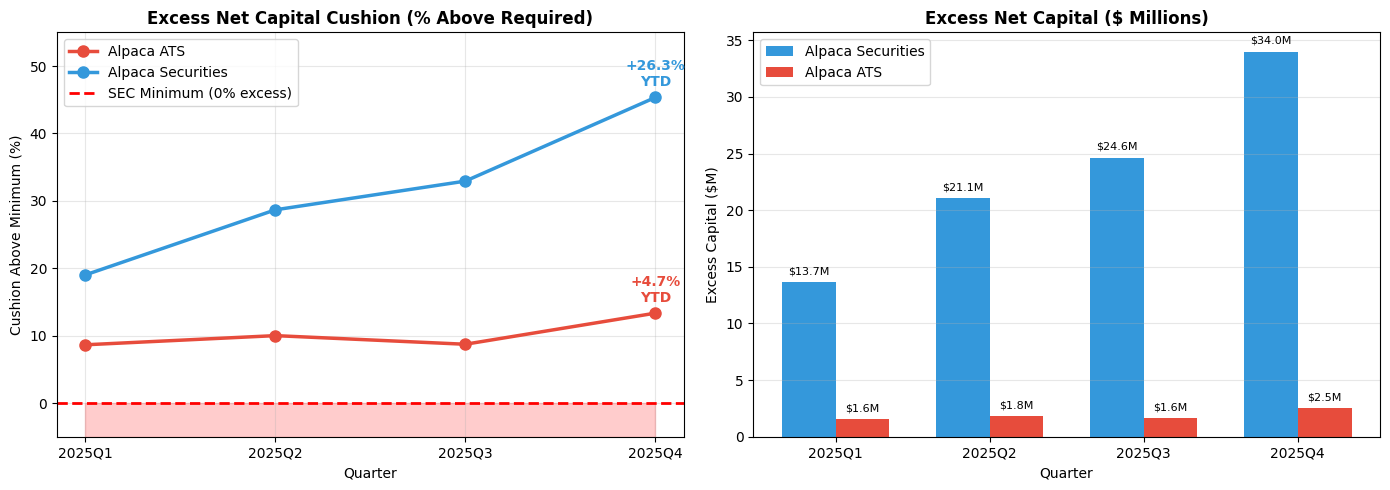

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'Alpaca ATS LLC': '#e74c3c', 'Alpaca Securities LLC': '#3498db'}

# Plot 1: Excess Capital Cushion % Over Time
for entity in capital_quarterly['entity_name'].unique():
    data = capital_quarterly[capital_quarterly['entity_name'] == entity].sort_values('quarter')
    axes[0].plot(data['quarter'].astype(str), data['cushion_pct'], 'o-', 
                 label=entity.replace(' LLC', ''), linewidth=2.5, markersize=8, color=colors[entity])

axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='SEC Minimum (0% excess)')
axes[0].fill_between(capital_quarterly['quarter'].astype(str).unique(), -5, 0, alpha=0.2, color='red')
axes[0].set_title('Excess Net Capital Cushion (% Above Required)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('Cushion Above Minimum (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-5, 55)

# Annotate growth
axes[0].annotate('+26.3%\nYTD', xy=(3, 47), fontsize=10, color='#3498db', fontweight='bold', ha='center')
axes[0].annotate('+4.7%\nYTD', xy=(3, 15), fontsize=10, color='#e74c3c', fontweight='bold', ha='center')

# Plot 2: Absolute Excess Capital ($)
width = 0.35
quarters = capital_quarterly['quarter'].astype(str).unique()
x = np.arange(len(quarters))

ats_excess = capital_quarterly[capital_quarterly['entity_name'] == 'Alpaca ATS LLC'].sort_values('quarter')['excess_net_capital'].values / 1e6
sec_excess = capital_quarterly[capital_quarterly['entity_name'] == 'Alpaca Securities LLC'].sort_values('quarter')['excess_net_capital'].values / 1e6

bars1 = axes[1].bar(x - width/2, sec_excess, width, label='Alpaca Securities', color='#3498db')
bars2 = axes[1].bar(x + width/2, ats_excess, width, label='Alpaca ATS', color='#e74c3c')

axes[1].set_title('Excess Net Capital ($ Millions)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Excess Capital ($M)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(quarters)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'${bar.get_height():.1f}M', 
                 ha='center', va='bottom', fontsize=8)
for bar in bars2:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'${bar.get_height():.1f}M', 
                 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# COMPLIANCE EXCEPTIONS & FINRA EXAM RISK ANALYSIS
# ============================================

import os
import psycopg2
import pandas as pd

# Load compliance exceptions data
conn = psycopg2.connect(
    host=os.environ['ALPACA_HOST'],
    port=int(os.environ.get('ALPACA_PORT', 5432)),
    database=os.environ['ALPACA_DATABASE'],
    user=os.environ['ALPACA_USERNAME'],
    password=os.environ['ALPACA_PASSWORD']
)

exceptions_df = pd.read_sql("SELECT * FROM alpaca_compliance_exceptions", conn)
exams_df = pd.read_sql("SELECT * FROM alpaca_regulatory_examinations", conn)
conn.close()

print(f"Loaded {len(exceptions_df)} compliance exceptions")
print(f"Loaded {len(exams_df)} regulatory examinations")
print(f"\nException columns: {list(exceptions_df.columns)}")
print(f"Exam columns: {list(exams_df.columns)}")

In [11]:
# ============================================
# OPEN COMPLIANCE EXCEPTIONS ANALYSIS
# ============================================

# Filter for open (unresolved) exceptions - exclude false positives
open_exceptions = exceptions_df[
    (exceptions_df['resolution_status'] != 'resolved') & 
    (exceptions_df['is_false_positive'] == False)
].copy()

print("=== OPEN COMPLIANCE EXCEPTIONS (FINRA EXAM RISK) ===\n")
print(f"Total Exceptions: {len(exceptions_df)}")
print(f"Open Exceptions:  {len(open_exceptions)}")
print(f"Resolved:         {len(exceptions_df[exceptions_df['resolution_status'] == 'resolved'])}")
print(f"False Positives:  {len(exceptions_df[exceptions_df['is_false_positive'] == True])}")

print("\n" + "=" * 60)
print("OPEN EXCEPTIONS BY SEVERITY")
print("=" * 60)
severity_counts = open_exceptions.groupby('severity').size().sort_values(ascending=False)
for severity, count in severity_counts.items():
    emoji = "🔴" if severity == 'critical' else "🟠" if severity == 'high' else "🟡" if severity == 'medium' else "🟢"
    print(f"  {emoji} {severity.upper():<10}: {count}")

print("\n" + "=" * 60)
print("OPEN EXCEPTIONS BY TYPE")
print("=" * 60)
type_counts = open_exceptions.groupby('exception_type').size().sort_values(ascending=False)
for exc_type, count in type_counts.items():
    print(f"  • {exc_type:<30}: {count}")

# Financial impact of open exceptions
total_impact = open_exceptions['financial_impact_usd'].sum()
print(f"\n💰 Total Financial Impact of Open Exceptions: ${total_impact:,.2f}")

=== OPEN COMPLIANCE EXCEPTIONS (FINRA EXAM RISK) ===

Total Exceptions: 115
Open Exceptions:  19
Resolved:         92
False Positives:  14

OPEN EXCEPTIONS BY SEVERITY
  🟢 MINOR     : 9
  🟢 MAJOR     : 7
  🔴 CRITICAL  : 3

OPEN EXCEPTIONS BY TYPE
  • net_capital_supporting_doc    : 4
  • price_outlier                 : 4
  • allocation_mismatch           : 2
  • duplicative_execution         : 2
  • late_trade_report             : 2
  • order_handling_exception      : 2
  • reserve_formula_variance      : 2
  • trade_break                   : 1

💰 Total Financial Impact of Open Exceptions: $7,243.16


In [12]:
# ============================================
# CRITICAL EXCEPTIONS DETAIL (HIGHEST FINRA RISK)
# ============================================

critical_exceptions = open_exceptions[open_exceptions['severity'] == 'critical'].copy()
major_exceptions = open_exceptions[open_exceptions['severity'] == 'major'].copy()

print("🚨 CRITICAL OPEN EXCEPTIONS (Requires Immediate Attention)")
print("=" * 80)
for _, row in critical_exceptions.iterrows():
    print(f"\n  Exception ID: {row['exception_id']}")
    print(f"  Date:         {row['exception_date']}")
    print(f"  Type:         {row['exception_type']}")
    print(f"  Status:       {row['resolution_status']}")
    print(f"  Assigned To:  {row['assigned_to']}")
    print(f"  Impact:       ${row['financial_impact_usd']:,.2f}")
    print(f"  Description:  {row['description'][:100]}...")

print("\n\n⚠️  MAJOR OPEN EXCEPTIONS")
print("=" * 80)
for _, row in major_exceptions.iterrows():
    print(f"\n  Exception ID: {row['exception_id']}")
    print(f"  Type:         {row['exception_type']}")
    print(f"  Status:       {row['resolution_status']}")
    print(f"  Assigned To:  {row['assigned_to']}")
    print(f"  Description:  {row['description'][:80]}...")

# Check upcoming/recent FINRA exams
print("\n\n" + "=" * 80)
print("📋 REGULATORY EXAMINATION HISTORY")
print("=" * 80)
finra_exams = exams_df[exams_df['examining_authority'] == 'FINRA'].sort_values('exam_start_date', ascending=False)
for _, exam in finra_exams.iterrows():
    status_emoji = "🟢" if exam['exam_status'] == 'closed' else "🟡" if exam['exam_status'] == 'in_progress' else "🔵"
    print(f"\n  {status_emoji} {exam['examination_id']} - {exam['exam_type']}")
    print(f"     Period: {exam['exam_start_date']} to {exam['exam_close_date']}")
    print(f"     Status: {exam['exam_status']} | Findings: {exam['total_findings']} ({exam['material_findings']} material)")
    print(f"     Disposition: {exam['overall_disposition']}")

🚨 CRITICAL OPEN EXCEPTIONS (Requires Immediate Attention)

  Exception ID: CE-00022
  Date:         2025-03-09
  Type:         duplicative_execution
  Status:       open
  Assigned To:  Clearing Liaison
  Impact:       $2,451.69
  Description:  Potential duplicate execution detected; validated against order trail....

  Exception ID: CE-00071
  Date:         2025-06-04
  Type:         net_capital_supporting_doc
  Status:       open
  Assigned To:  Trade Support
  Impact:       $1,749.32
  Description:  Supporting documentation missing for net capital line item....

  Exception ID: CE-00072
  Date:         2025-06-07
  Type:         duplicative_execution
  Status:       open
  Assigned To:  Clearing Liaison
  Impact:       $1,576.92
  Description:  Potential duplicate execution detected; validated against order trail....


⚠️  MAJOR OPEN EXCEPTIONS

  Exception ID: CE-00046
  Type:         order_handling_exception
  Status:       under_review
  Assigned To:  Supervisory Principal
  Desc